The derivative property of the fourier transform can be used to compute the derivative of a function by multiplying the fft by a constant factor -ik. This method should in general be much slower than finite difference methods since fft and ifft have nlogn runtime while finite difference methods are linear. But maybe there's a gain in accuracy that can compensate for this cost? 

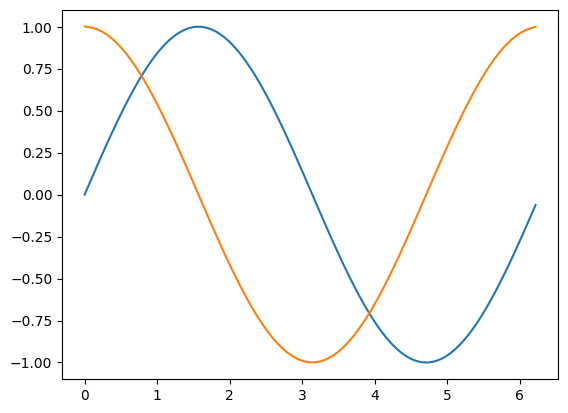

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt


def second_order_diff(x, dx):
    df = np.zeros(len(x))

    for i in range(1,len(x)-1):
        df[i] = (x[i+1] - x[i-1])/(2*dx)

    df[0] = (-3*x[0] +4*x[1] - x[2])/(2*dx)
    df[len(x)-1] = (3*x[len(x)-1] -4*x[len(x)-2] + x[len(x)-3])/(2*dx)
    return df

def fourth_order_diff(x):
    df = np.zeros(len(x))

    return df

def spectral_deriv(x):
    f = sp.fft.fft(x)
    N = len(f)
    k2=np.zeros(N)

    if ((N%2)==0):                                                                               
        for i in range(1,N//2):
            k2[i]=i
            k2[N-i]=-i
    else:                                                                                  
        for i in range(1,(N-1)//2):
            k2[i]=i
            k2[N-i]=-i

    df = np.real(sp.fft.ifft(f*k2*1j))
    return df

N = 101
t = 2*np.pi*np.arange(0,N,1)/N
x = np.sin(t)
dx = spectral_deriv(x)
plt.plot(t, x, t, second_order_diff(x, t[1]-t[0]))
plt.show()

FFT derivative also comes with extra strings attached since if we dont have a function that is periodic the results will be ruined by Gibbs phenomena. To deal with this we'd have to extend our function and work on a larger array to obtain useful results which further increases the computational work.

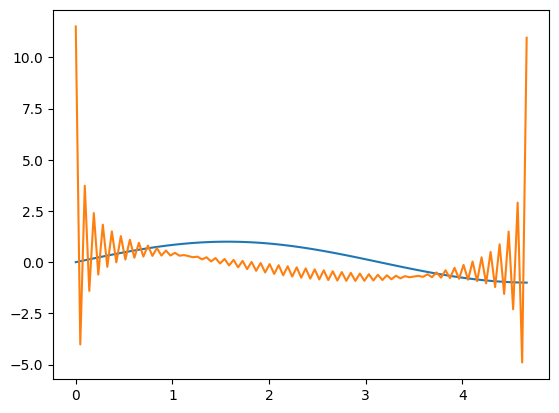

In [32]:
N = 101
t = 1.5*np.pi*np.arange(0,N,1)/N
x = np.sin(t)
dx = spectral_deriv(x)
plt.plot(t, x, t, dx)
plt.show()

Lets compare the accuracy of each approach to see if we get a substantial gain from using the fft method

In [20]:
s_error = np.abs(np.cos(t) - spectral_deriv(np.sin(t)))
fd2_error = np.abs(np.cos(t) - second_order_diff(np.sin(t), t[1]-t[0]))

print(s_error.max())
print(fd2_error.max())
print(np.sum(s_error))
print(np.sum(fd2_error))

2.5424107263916085e-14
0.0012882712532182872
4.2991304960438015e-13
0.04274860768846058


Comparing the error for each method we can see an astronomical difference in performance so this may be worthwhile if we need super high precision for numerical stability
Lets take a look now at what happens as we crank up the number of points used, the finite difference approach should improve as we get a better approximation to the gradient using pointss that are closer together

In [6]:
N = 500
t = 2*np.pi*np.arange(0,N,1)/N
s_error = np.abs(5*np.cos(5*t) + 2*np.sin(2*t) - spectral_deriv(np.sin(5*t) - np.cos(2*t)))
fd2_error = np.abs(5*np.cos(5*t) + 2*np.sin(2*t) - second_order_diff(np.sin(5*t) - np.cos(2*t), t[1]-t[0]))

print('error for 500 points \n')
print(s_error.max())
print(fd2_error.max())
print(np.sum(s_error))
print(np.sum(fd2_error))

N = 1000
t = 2*np.pi*np.arange(0,N,1)/N
s_error = np.abs(5*np.cos(5*t) + 2*np.sin(2*t) - spectral_deriv(np.sin(5*t) - np.cos(2*t)))
fd2_error = np.abs(5*np.cos(5*t) + 2*np.sin(2*t) - second_order_diff(np.sin(5*t) - np.cos(2*t), t[1]-t[0]))

print('\nerror for 1000 points \n')
print(s_error.max())
print(fd2_error.max())
print(np.sum(s_error))
print(np.sum(fd2_error))

error for 500 points 

8.908429549592256e-13
0.006578585307130069
5.2582901079550633e-11
1.0544740160936017

error for 1000 points 

1.737276988933445e-12
0.0016453580810207313
2.1373667388009258e-10
0.5257300987544141


The fft method seems the be better at a lower number of points, possibly a result of rounding error on account of a much higher number of operations being done when compared to the finite difference approach. Maybe the value of the fft method is actually that we could simulate fewer points even though it has a worse running time? Similar to the reasons why implicit finite difference schemes for PDEs are sometimes prefered to explicit ones.

And of course as you can see below the method doesnt work at all if we dont have a function that extends to a smooth periodic function with a continuous derivative

In [7]:
N = 500
t = 2*np.pi*np.arange(0,N,1)/N
s_error = np.abs(2*t - spectral_deriv(t**2))
fd2_error = np.abs(2*t - second_order_diff(t**2, t[1]-t[0]))

print('error for 500 points \n')
print(s_error.max())
print(fd2_error.max())
print(np.sum(s_error))
print(np.sum(fd2_error))

N = 1000
t = 2*np.pi*np.arange(0,N,1)/N
s_error = np.abs(2*t - spectral_deriv(t**2))
fd2_error = np.abs(2*t - second_order_diff(t**2, t[1]-t[0]))

print('\nerror for 1000 points \n')
print(s_error.max())
print(fd2_error.max())
print(np.sum(s_error))
print(np.sum(fd2_error))

error for 500 points 

2175.1486371792544
1.085354028873553e-12
19878.631573277933
4.544564724540123e-11

error for 1000 points 

4352.739864177513
1.2683187833317788e-12
44147.89644215563
1.900138935084783e-10
